In [2]:
import pickle
from apply_loocv_and_save import *

    


apply_loocv_and_save(
    results_filepath="../data/cv_train_test_ns_5subjs_outer_n_loocv.pkl",
    brain_data_filepath = '../data/Brain_Data_ns_5subs.pkl',
    train_test_markers_filepath = "../data/train_test_markers_20210601T183243.csv",
    response_transform_func =transform_normalize
    
)


In [3]:
cpus_available = int(os.getenv('CPUS_PER_TASK'))
cpus_to_use = cpus_available-1

Purpose: writing a tweaked version of our `apply_loocv_and_save` function below that also runs the function one more time in order to get some betas.

We should also write a modified version that _only_ does that so that we don't have to redo all our analyses.

In [4]:
from apply_loocv_and_save import *
results_filepath="../data/cv_train_test_ns_5subjs_outer_n_loocv.pkl"

# def apply_loocv_and_save(
#     results_filepath,
#     brain_data_filepath = '../data/Brain_Data_2sns_60subs.pkl',
#     train_test_markers_filepath = "../data/train_test_markers_20210601T183243.csv",
#     subjs_to_use = None, #set this to get a subset, otherwise use all of them.
#     response_transform_func = None
#     ):

results_filepath
brain_data_filepath = '../data/Brain_Data_2sns_60subs.pkl'
train_test_markers_filepath = "../data/train_test_markers_20210601T183243.csv"
subjs_to_use = 20 #set this to get a subset, otherwise use all of them.
response_transform_func = None

#pd.set_option('display.max_rows', 99)
test_train_set = pd.read_csv(train_test_markers_filepath)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

dev_wtp_io_utils.check_BD_against_test_train_set(Brain_Data_allsubs,test_train_set)

#################################################
#######PRE-PROCESS


if response_transform_func is None:
    Brain_Data_allsubs.Y = Brain_Data_allsubs.X['response'].copy()
else:
    Brain_Data_allsubs.Y = response_transform_func(Brain_Data_allsubs.X)


print(Brain_Data_allsubs.Y.value_counts())
Brain_Data_allsubs.Y[Brain_Data_allsubs.Y=='NULL']=None
print(Brain_Data_allsubs.Y.value_counts())

import sys
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print(name + ': ' + str(size))
print(Brain_Data_allsubs.Y.isnull().value_counts())
Brain_Data_allsubs_nn = Brain_Data_allsubs[Brain_Data_allsubs.Y.isnull()==False]
print(len(Brain_Data_allsubs_nn))
print(len(Brain_Data_allsubs))


all_subs_nn_nifti = Brain_Data_allsubs_nn.to_nifti()
all_subs_nn_nifti_Y = Brain_Data_allsubs_nn.Y
all_subs_nn_nifti_groups = Brain_Data_allsubs_nn.X.subject
all_subs_nn_nifti_groups


all_subs_nn_nifti_metadata = Brain_Data_allsubs_nn.X


#################################################
#######GET SUB-SET


del Brain_Data_allsubs
#del Brain_Data_allsubs_grouped
gc.collect()

from nilearn.decoding import DecoderRegressor
cv_inner = GroupKFold(3)
dRegressor = DecoderRegressor(standardize= True,cv=cv_inner,scoring="r2",
                                  n_jobs=cpus_to_use)


print(asizeof_fmt(Brain_Data_allsubs_nn))

print(asizeof_fmt(all_subs_nn_nifti))

if subjs_to_use is None:
    subjs_to_use=len(np.unique(all_subs_nn_nifti_groups))

sample_subject_items = np.unique(all_subs_nn_nifti_groups)[0:subjs_to_use] #get all of them
sample_subject_vector = [i for i, x in enumerate(all_subs_nn_nifti_groups) if x in sample_subject_items]

first_subs_nifti = nib.funcs.concat_images([all_subs_nn_nifti.slicer[...,s] for s in sample_subject_vector])
first_subs_nifti_Y = all_subs_nn_nifti_Y[sample_subject_vector]
first_subs_nifti = nil.image.clean_img(first_subs_nifti,detrend=False,standardize=True)
first_subs_nifti_groups = all_subs_nn_nifti_groups[sample_subject_vector]

del all_subs_nn_nifti
gc.collect()

first_subs_nifti_metadata = all_subs_nn_nifti_metadata.loc[sample_subject_vector,:]

print("starting LeaveOneOut")
#in this design, we're actually dealing with groups
#we select group IDs and then grab the subjects
#so we don't need to use LeaveOneGroupOut
#the grouping is implicit
cv_outer = LeaveOneOut()

print("finished preprocessing")




# test_scores_same,tt_results,results_by_trainset_item = cv_train_test_sets(
#     trainset_X=first_subs_nifti,
#     trainset_y=first_subs_nifti_Y,
#     trainset_groups=first_subs_nifti_groups,
#     regressors=[dRegressor],
#     cv=cv_outer,
#     cpus_to_use=cpus_available

# )

print("regressing one final time to get the betas")

#now, let's run this once on the entire set, not to train but to find out what features are being highlighted.
regress_result = dRegressor.fit(
    y=first_subs_nifti_Y,X=first_subs_nifti,groups=first_subs_nifti_groups)

weight_img = dRegressor.coef_img_['beta']



checked for intersection and no intersection between the brain data and the subjects was found.
there were 60 subjects overlapping between the subjects marked for train data and the training dump file itself.
5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
5.0    1164
6.0    1018
7.0     904
8.0     604
Name: response, dtype: int64
all_subs_nn_nifti_metadata: 2484304
all_subs_nn_nifti_groups: 232614
all_subs_nn_nifti_Y: 29664
test_train_set: 9549
_iii: 4100
_i1: 4100
_i4: 4100
KFold: 1064
GroupKFold: 1064
LeaveOneOut: 1064
False    3690
True      150
Name: response, dtype: int64
3690
3840
3.3 GiB
12.4 GiB
starting LeaveOneOut
finished preprocessing
regressing one final time to get the betas


NameError: name 'test_scores_same' is not defined

In [8]:
from nilearn import plotting


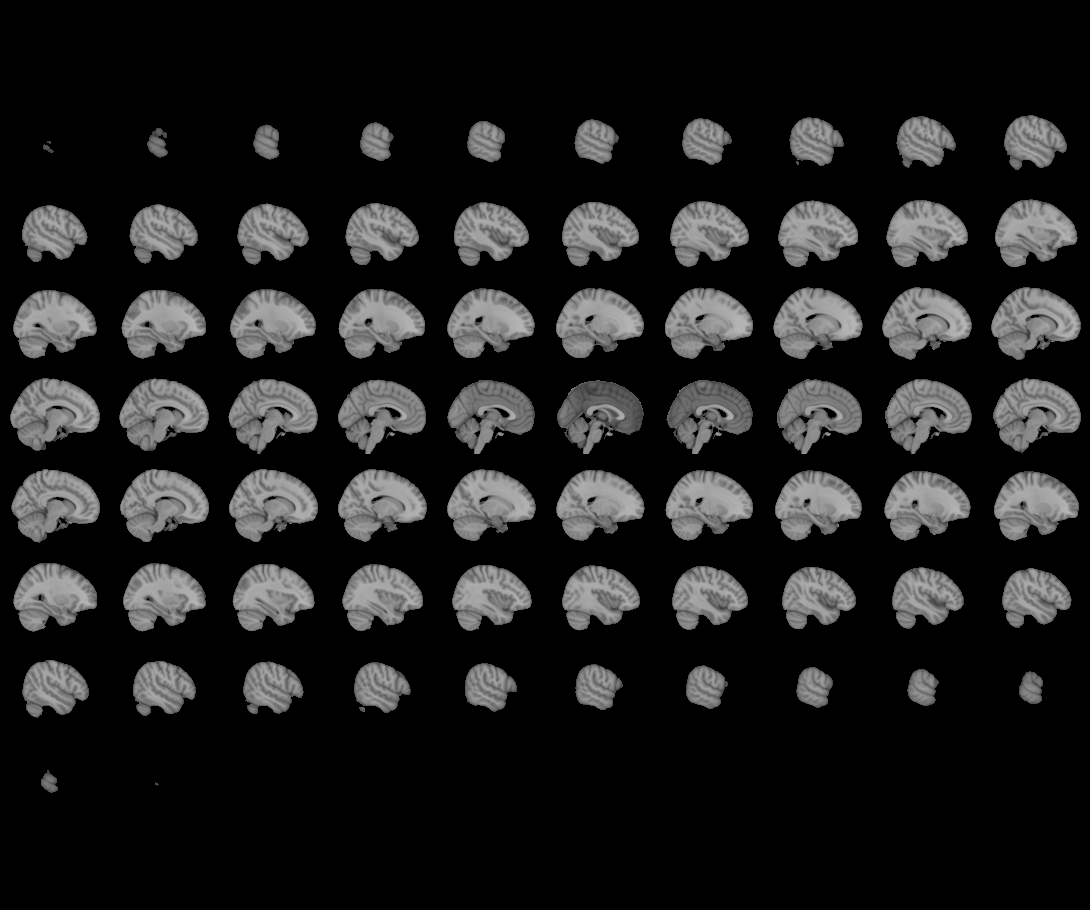
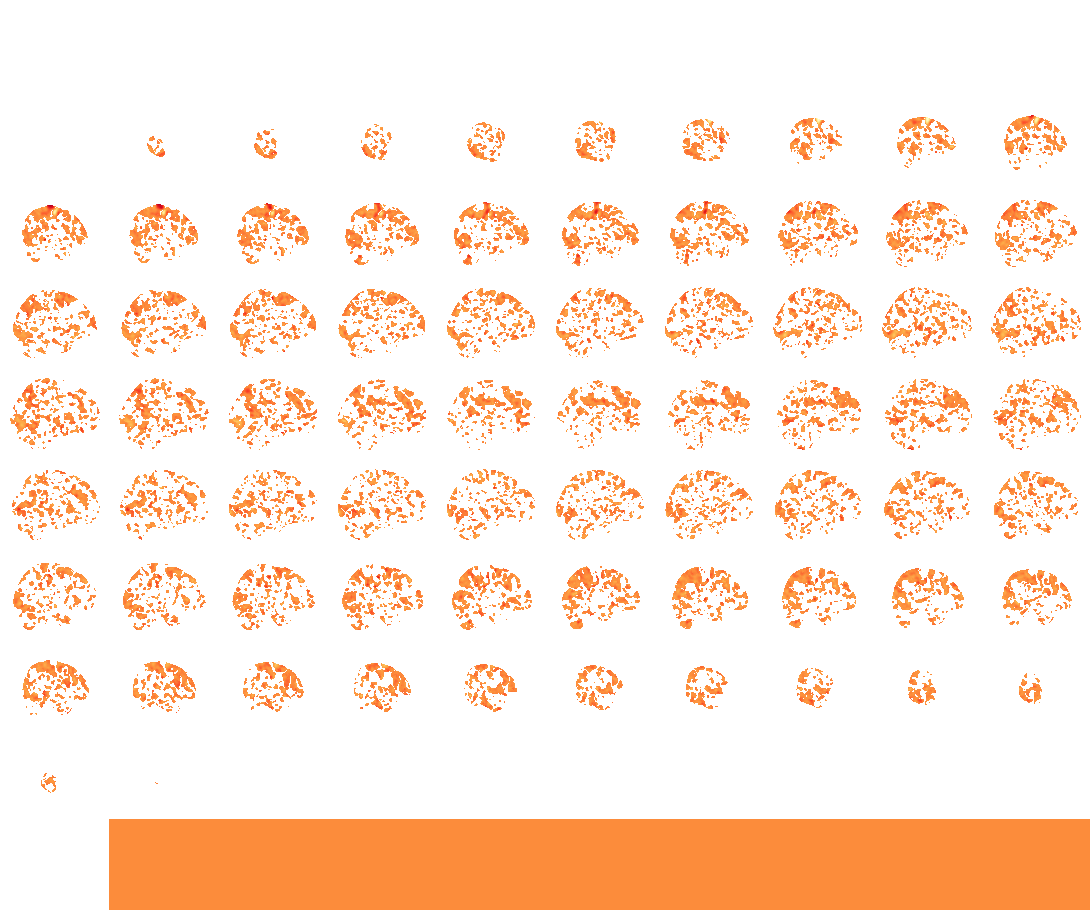

In [13]:
plotting.view_img(weight_img,opacity=0.9,cmap='YlOrRd')